In [20]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import graphviz

In [6]:
df = pd.read_csv('ShootingSplits_HeatCheckTourwTrap.csv')
df.tail(2)

,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,POWER,PATH,DRAW,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,Within Trapezoid of Excellence
318,318,2019,741,241,Wofford,SC,92.6,6.3,85.7,4.0,...,71.8,70.7,0.46,1,14.5,23,28,0.227,1.1,0
319,319,2019,740,245,Yale,Ivy,94.3,9.3,82.6,4.1,...,58.4,75.7,0.66,0,3.6,48,53,0.613,-17.3,0


In [7]:
df = df.dropna(axis=1)
df_train = df[df['YEAR'] != 2024]
df_test = df[df['YEAR'] == 2024]
df_train.shape

(256, 48)

In [8]:
X_train = df_train.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
X_test = df_test.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
y_train = df_train.WINS
y_test = df_test.WINS
y_test.head(5)

0    0
1    4
2    2
3    0
4    1
Name: WINS, dtype: int64

In [9]:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [10]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [11]:
dtree.score(X_train,y_train)

0.5703125

In [12]:
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 6)
print(dtree_string)

|------ POOL VALUE <= 0.1
|      |------ PATH <= 0.6
|      |      |------ class: 0
|      |------ PATH >  0.6
|      |      |------ class: 0
|------ POOL VALUE >  0.1
|      |------ THREES D SHARE <= 0.3
|      |      |------ class: 1
|      |------ THREES D SHARE >  0.3
|      |      |------ class: 2



In [13]:
cv_results = cross_validate(dtree,X_train,y_train)
acc_valid = cv_results['test_score'].mean()
print('validation accuracy rate',acc_valid)

validation accuracy rate 0.503921568627451


C:\Users\hobbsji\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [14]:
dtree.score(X_test,y_test)

0.53125


best alpha = {'max_depth': 2}   valid R2 = 0.193


<Axes: xlabel='depth'>

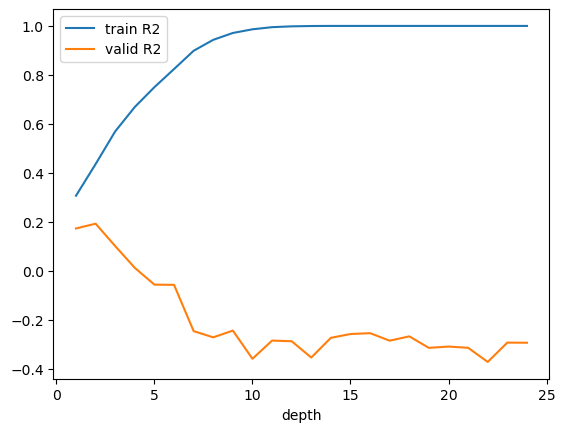

In [15]:
grid = {'max_depth':np.arange(1,25)}

dtree = DecisionTreeRegressor()
dtreeCV = GridSearchCV(dtree,param_grid=grid,return_train_score=True)
dtreeCV.fit(X_train,y_train)

print()
print('best alpha =',dtreeCV.best_params_, '  valid R2 =',dtreeCV.best_score_.round(3))

results = pd.DataFrame()
results['depth']    = grid['max_depth']
results['train R2'] = dtreeCV.cv_results_['mean_train_score']
results['valid R2'] = dtreeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train R2')
results.plot.line(x='depth',y='valid R2',ax=ax1)

In [22]:
grid = {'n_estimators':[10,100,200],'max_depth':np.arange(1,30)}
rf = RandomForestRegressor(n_jobs=-1)
rfCV = GridSearchCV(rf,param_grid=grid,n_jobs=-1)
rfCV.fit(X_train,y_train)
print('best parameter',rfCV.best_params_)
print('validation R2',rfCV.best_score_.round(2))

best parameter {'max_depth': 16, 'n_estimators': 200}
validation R2 0.3


In [23]:
rf_opt = rfCV.best_estimator_
R2_train = rf_opt.score(X_train,y_train)
R2_test  = rf_opt.score(X_test,y_test)
print('Forest -> train R2 =',R2_train.round(3),'  test R2 =',R2_test.round(3))


Forest -> train R2 = 0.896   test R2 = 0.405
